In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 
from math import sqrt
import pandas_market_calendars as mcal

import warnings
warnings.filterwarnings('ignore')

STOCK = "AAPL"

# Importing Dataset for Stocks

In [2]:
def load_csv(ticker):
    end = datetime.now()
    start = end - timedelta(days=15*365)
    
    stock_data = yf.download(ticker, start=start, end=end)
    stock_data.reset_index(inplace=True)
    
    return stock_data
    
df = load_csv(STOCK)
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-05-08,6.563214,6.660714,6.538214,6.609286,5.625285,899085600
1,2008-05-09,6.541429,6.580357,6.477500,6.551786,5.576345,673072400
2,2008-05-12,6.614643,6.745357,6.530357,6.720000,5.719514,818563200
3,2008-05-13,6.736071,6.837500,6.709286,6.784286,5.774231,823236400
4,2008-05-14,6.829643,6.865714,6.627500,6.652143,5.661761,916823600
...,...,...,...,...,...,...,...
3769,2023-04-28,168.490005,169.850006,167.880005,169.679993,169.679993,55209200
3770,2023-05-01,169.279999,170.449997,168.639999,169.589996,169.589996,52472900
3771,2023-05-02,170.089996,170.350006,167.539993,168.539993,168.539993,48425700
3772,2023-05-03,169.500000,170.919998,167.160004,167.449997,167.449997,65136000


# Dropping Irrelevant Columns In The Dataset

In [3]:
df = df.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis="columns")
df["Prev_Close"] = df.loc[:, "Close"].shift(1)
df

,Date,Close,Prev_Close
0,2008-05-08,6.609286,NaN
1,2008-05-09,6.551786,6.609286
2,2008-05-12,6.720000,6.551786
3,2008-05-13,6.784286,6.720000
4,2008-05-14,6.652143,6.784286
...,...,...,...
3769,2023-04-28,169.679993,168.410004
3770,2023-05-01,169.589996,169.679993
3771,2023-05-02,168.539993,169.589996
3772,2023-05-03,167.449997,168.539993


# Calculating EMA 6, 18, 60, 120, 200

Text(0, 0.5, 'Price')

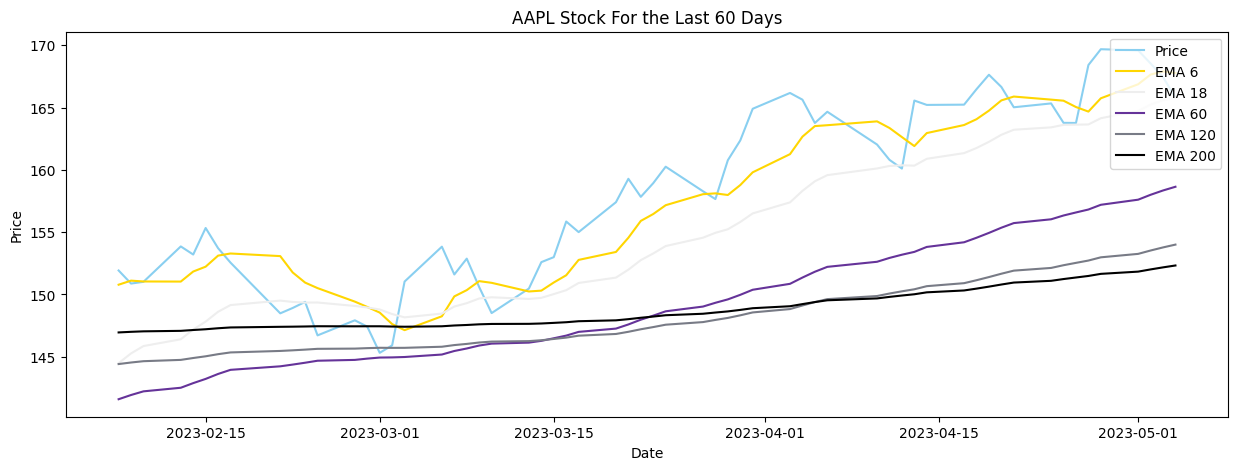

In [4]:
df["EMA 6"] = df["Prev_Close"].ewm(span=6, adjust=False).mean()
df["EMA 18"] = df["Prev_Close"].ewm(span=18, adjust=False).mean()
df["EMA 60"] = df["Prev_Close"].ewm(span=60, adjust=False).mean()
df["EMA 120"] = df["Prev_Close"].ewm(span=120, adjust=False).mean()
df["EMA 200"] = df["Prev_Close"].ewm(span=200, adjust=False).mean()

# Plotting Values
plt.figure(figsize=(15, 5))

plt.plot(df["Date"][-60:], df["Close"][-60:], color="#89CFF0", label="Price")
plt.plot(df["Date"][-60:], df["EMA 6"][-60:], color="#FFD601", label="EMA 6")
plt.plot(df["Date"][-60:], df["EMA 18"][-60:], color="#EEEEEE", label="EMA 18")
plt.plot(df["Date"][-60:], df["EMA 60"][-60:], color="#653399", label="EMA 60")
plt.plot(df["Date"][-60:], df["EMA 120"][-60:], color="#787B86", label="EMA 120")
plt.plot(df["Date"][-60:], df["EMA 200"][-60:], color="#000000", label="EMA 200")

plt.legend(loc='upper right')
plt.title("{} Stock For the Last 60 Days".format(STOCK))
plt.xlabel("Date")
plt.ylabel("Price")


# Creating MACD Indicator
### MACD or Moving Average Convergence Divergence is an index which compares the short term EMA (6 days) and long term EMA (60 days) to make judgements on the momentum of a stock

Text(0, 0.5, 'MACD')

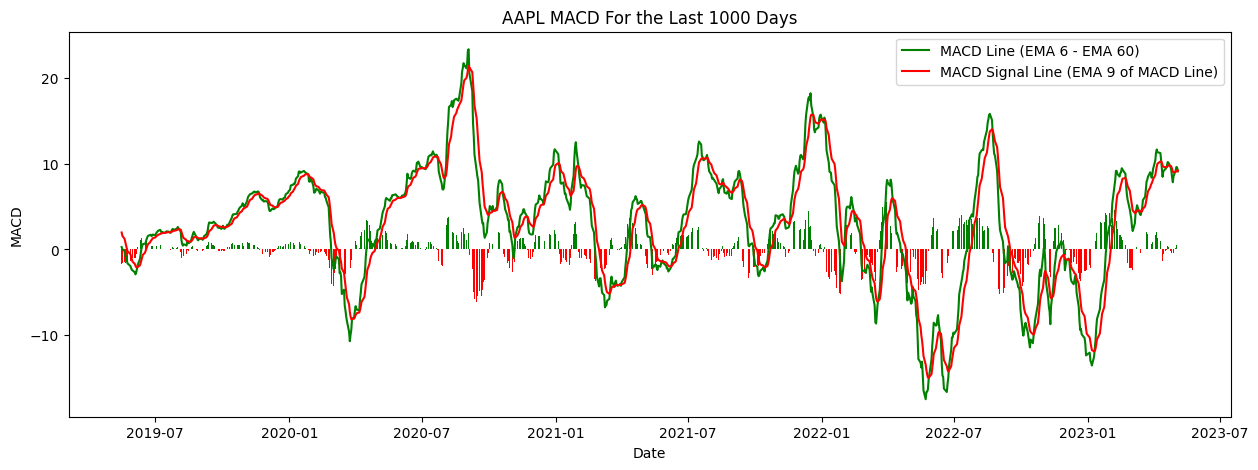

In [5]:
def generateMACD(df, low=6, high=60):
    lowEMA = "EMA {}".format(low)
    highEMA = "EMA {}".format(high)
    
    dfMACD = {
        "MACD": df[lowEMA] - df[highEMA] # Use Prev_Close for now because of generateEMA() function
    }
    
    dfMACD["MACD_Signal"] = dfMACD["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD"] = dfMACD["MACD"] - dfMACD["MACD_Signal"]
    df["MACD Signal"] = dfMACD["MACD_Signal"]
    
    return df, dfMACD["MACD"], dfMACD["MACD_Signal"]

df, MACD_Line, MACD_Signal_Line = generateMACD(df)


# Plotting MACD
plt.figure(figsize=(15, 5))
cols = ['red' if x < 0 else 'green' for x in df["MACD"][-1000:]]
plt.bar(df["Date"][-1000:], df["MACD"][-1000:], color=cols)
plt.plot(df["Date"][-1000:], MACD_Line[-1000:], color="green", label="MACD Line (EMA 6 - EMA 60)")
plt.plot(df["Date"][-1000:], MACD_Signal_Line[-1000:], color="red", label="MACD Signal Line (EMA 9 of MACD Line)")

plt.legend(loc='upper right')
plt.title("{} MACD For the Last 1000 Days".format(STOCK))
plt.xlabel("Date")
plt.ylabel("MACD")

# Splitting the Dataset For Training and Testing Datasets

In [6]:
x = df.drop(["Date", "Close"], axis="columns").iloc[1:]
y = df["Close"].iloc[1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

RMSE: 1.2776759794432853
Normalized RMSE: 0.009199248306749775


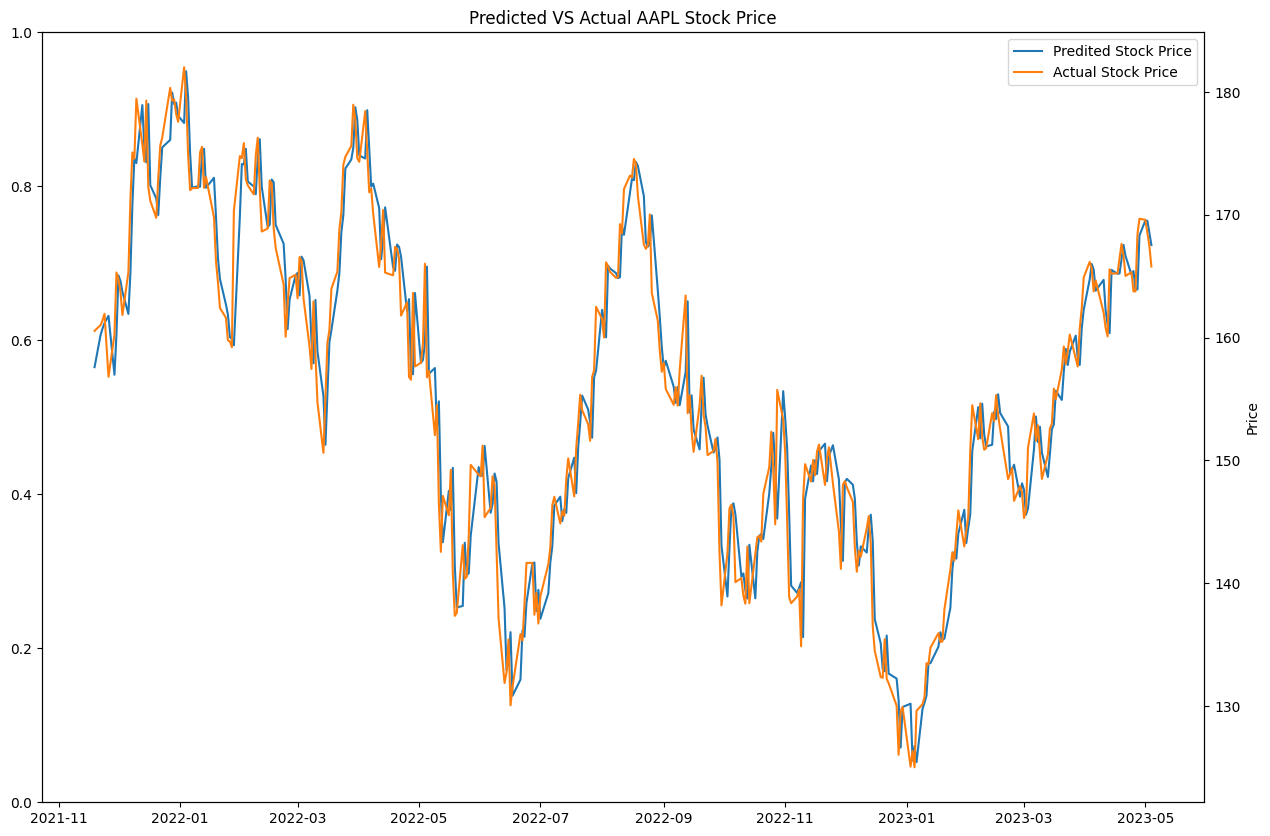

In [7]:
lr = LinearRegression().fit(x_train, y_train)

# One for Determining RMSE Value and One for Graphing
pred1 = lr.predict(x_test)
pred2 = lr.predict(x)

RMSE = mean_squared_error(y_test, pred1)

normRMSE = RMSE / (max(y_test) - min(y_test))
print("RMSE: " + str(sqrt(RMSE)))
print("Normalized RMSE: " + str(normRMSE))

def displayPerformance(model, x, actualPrice, dates, numberOfDays, show=True):
    # Dates and Generating Predictions
    xPlot = dates[-numberOfDays:]
    pred = model.predict(x)
    
    # Creating Error Plot Expressed as a Percentage
    error = pd.DataFrame({
        "Date": xPlot,
        "Error": ((actualPrice[-numberOfDays:]-pred[-numberOfDays:])/actualPrice[-numberOfDays:])*100
    })
        
    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    if show:
        cols = ['red' if x < 0 else 'green' for x in error["Error"]]
        ax1.bar(xPlot, error["Error"], color=cols)
        ax1.set_ylabel('Percent Error')
    
    
    ax2 = ax1.twinx()
    ax2.plot(xPlot, pred[-numberOfDays:], label="Predited Stock Price")
    ax2.plot(xPlot, actualPrice[-numberOfDays:], label="Actual Stock Price")
    ax2.set_ylabel('Price')
    
    plt.legend(loc='upper right')
    plt.title("Predicted VS Actual {} Stock Price".format(STOCK))
    
    plt.show()
    
    return error

error = displayPerformance(lr, x, df["Close"], df["Date"], 365, False)

# Next 30 Days Of Apple Stock Predicted 

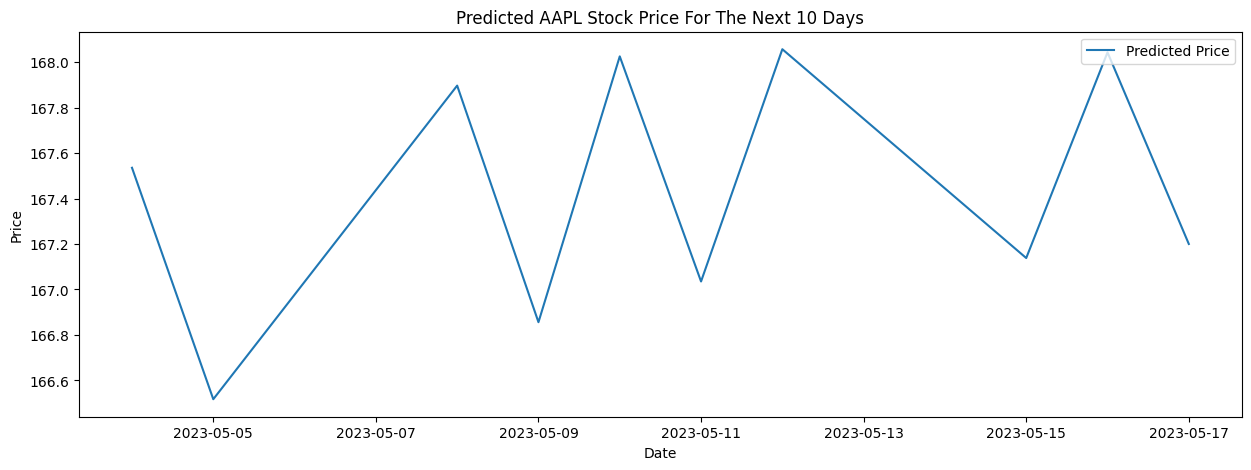

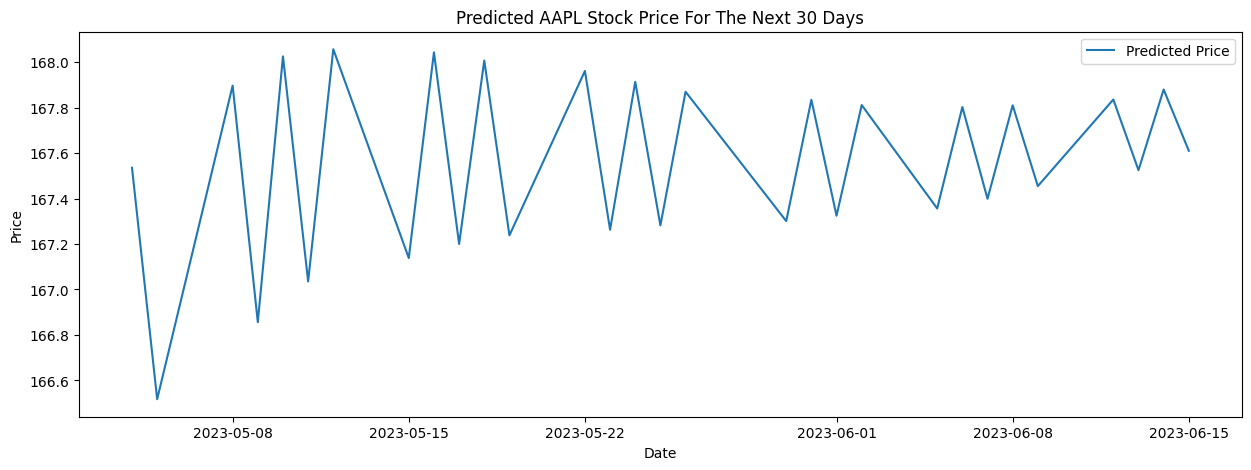

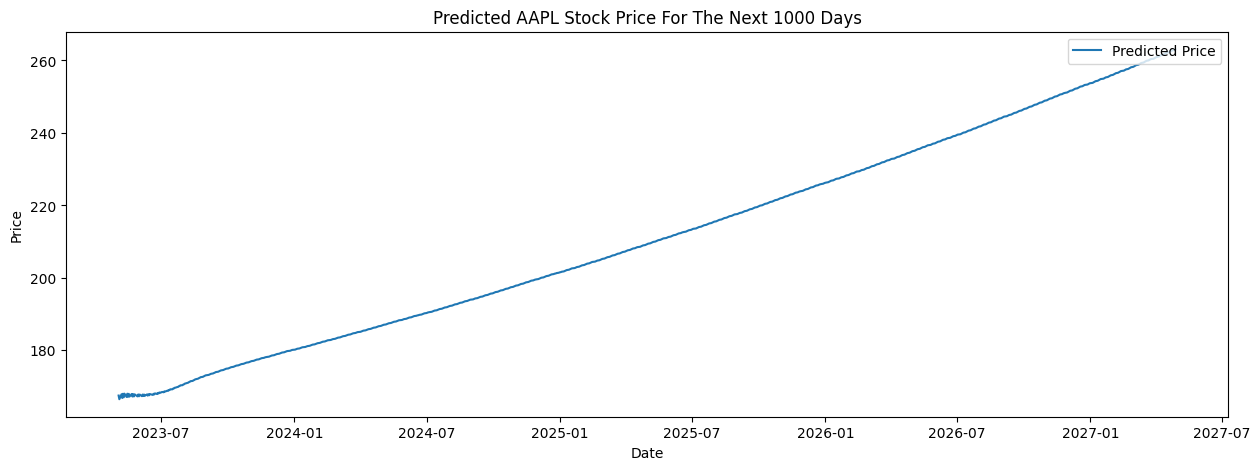

In [8]:
def predictFuture(df, model, days, show=True):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date='today', end_date='2027-12-31')

    for i in range(days):
        # Generating New Prediction
        row = df.shape[0]
        predictionData = df.drop(["Date", "Close"], axis="columns").iloc[row-1]
        newPrediction = model.predict(np.array(predictionData).reshape(1, -1))
        
        # Adding New Values and appending to df
        row = df.shape[0]
        newDf = pd.DataFrame({
            "Date": schedule.iloc[i].name,
            "Close": newPrediction,
            "Prev_Close": df["Close"].iloc[row-1],
            "EMA 6": df["Prev_Close"].ewm(span=6).mean().iloc[-1],
            "EMA 18": df["Prev_Close"].ewm(span=18).mean().iloc[-1],
            "EMA 60": df["Prev_Close"].ewm(span=60).mean().iloc[-1],
            "EMA 120": df["Prev_Close"].ewm(span=120).mean().iloc[-1],
            "EMA 200": df["Prev_Close"].ewm(span=200).mean().iloc[-1],
            "MACD": df["Prev_Close"].ewm(span=60).mean().iloc[-1] - df["Prev_Close"].ewm(span=6).mean().iloc[-1],
            "MACD Signal": df["MACD"].ewm(span=9).mean().iloc[-1] 
        })

        df = pd.concat([df, newDf], axis=0)
    
    # Plotting
    if show:
        plt.figure(figsize=(15, 5))
        plt.plot(df["Date"][-days:], df["Close"][-days:], label="Predicted Price")

        plt.legend(loc='upper right')
        plt.title("Predicted {} Stock Price For The Next {} Days".format(STOCK, days))
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()

    return df
        
newDf1 = predictFuture(df, lr, 10)
newDf3 = predictFuture(df, lr, 30)
newDf4 = predictFuture(df, lr, 1000)

## STEPS FOR IMPROVMENT
- The RMSE value is too high, meaning we potentially over-fitting issues
- Doesn't account for multiple technical indicator (beyond MACD and EMA)
- No GUI system set-up

In [18]:
import joblib
import pickle

In [25]:
pickle.dump(lr, open("model.pkl", "wb"))
print(type(lr))

<class 'sklearn.linear_model._base.LinearRegression'>


<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._base.LinearRegression'>


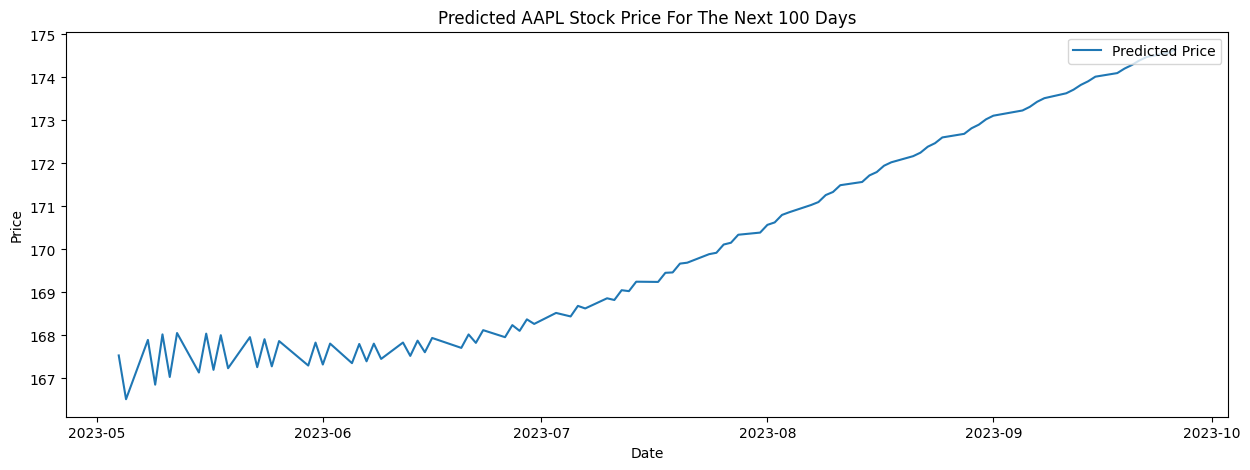

In [28]:
with open("model.pkl", "rb") as file1:
    m = pickle.load(file1)
    print(type(m))

print(type(m))
newDf1 = predictFuture(df, m, 100)


In [29]:
pickle.dump(df, open("df.pkl", "wb"))

In [30]:
newDf1

,Date,Close,Prev_Close,EMA 6,EMA 18,EMA 60,EMA 120,EMA 200,MACD,MACD Signal
0,2008-05-08,6.609286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-05-09,6.551786,6.609286,6.609286,6.609286,6.609286,6.609286,6.609286,0.000000,0.000000
2,2008-05-12,6.720000,6.551786,6.592857,6.603233,6.607401,6.608335,6.608714,-0.011635,-0.002909
3,2008-05-13,6.784286,6.720000,6.629184,6.615524,6.611092,6.610181,6.609821,0.016800,0.001291
4,2008-05-14,6.652143,6.784286,6.673499,6.633289,6.616771,6.613059,6.611557,0.044349,0.012379
...,...,...,...,...,...,...,...,...,...,...
0,2023-09-20,174.288326,174.205628,173.862863,173.243602,171.016376,167.269570,163.350526,-2.846487,-2.874147
0,2023-09-21,174.390979,174.288326,173.960796,173.344868,171.120942,167.384215,163.458537,-2.839854,-2.868615
0,2023-09-22,174.473277,174.390979,174.054376,173.444179,171.224791,167.498333,163.566296,-2.829585,-2.862863
0,2023-09-25,174.573579,174.473277,174.150548,173.543842,171.328600,167.612261,163.674004,-2.821948,-2.856208
